Consensus optimizztion

Using cvxpy:

In [0]:
import numpy as np
import time

np.random.seed(1)

m = 10
n = 20
A = np.random.rand(m, n)
y = np.random.rand(m,)

#син

In [0]:
import cvxpy as cp

x = cp.Variable(shape=n)

delta = A @ x - y

In [3]:
from cvxpy import *
import numpy as np
from multiprocessing import Process, Pipe

# Number of terms f_i. Choose N so that m / N - integer
N = 2
    
length = m // N

# A list of all the A_i.
A_list = [A[i * length: (i + 1) * length] for i in range(N)]
# A list of all the y_i
y_list = [y[i * length: (i + 1) * length] for i in range(N)]

# Set MAX_ITER
MAX_ITER = 5000

start = time.time()

def run_cxvpy(A, y, x0, pipe):
    
    x = cp.Variable(n, value=x0)
    f = cp.sum_squares(A @ x - y)
    prox = Problem(Minimize(f))
    # ADMM loop.
    i = 0
    while True:
        #print(i, end='\n')
        i += 1
        prox.solve()
        pipe.send(x.value)
        x.value = pipe.recv()


x0 = np.random.rand(n)
error = np.absolute(A.dot(x0) - y).mean()
#print(error)
cvxpy_errors = [error]
# Setup the workers.
pipes = []
procs = []
for i in range(N):
    local, remote = Pipe()
    pipes += [local]
    procs += [Process(target=run_cxvpy, args=(A_list[i], y_list[i], x0, remote))]
    procs[-1].start()

# ADMM loop.
for i in range(MAX_ITER):
    #print(i, end='\n')
    # Gather and average xi
    x_local = [pipe.recv() for pipe in pipes]
    xbar = sum(x_local) / N
    error = np.absolute(A.dot(xbar) - y).mean()
    #print(error)
    cvxpy_errors.append(error)
    #print(xbar)
    # Scatter xbar
    for pipe in pipes:
        pipe.send(xbar)

cvxpy_time = time.time() - start

[p.terminate() for p in procs]
print('OK!')

OK!


Using torch:

In [0]:
import torch

A_t = torch.tensor(A, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

In [5]:
import torch


start = time.time()

def run_torch(A, y, x0, pipe):

    #print('Start')
    A_t = torch.tensor(A, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    x = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
    opt = torch.optim.SGD([x], lr=1e-3)
    loss_fn = torch.nn.MSELoss()
    # ADMM loop.
    i = 0
    #print('Go')
    while True:
        #print(i, end='\r')
        i += 1
        #print(i)
        loss = loss_fn(A_t @ x, y_t)
        #print('loss = {}'.format(loss))
        loss.backward()
        #print('backward')
        opt.step()
        opt.zero_grad()
        pipe.send(x.detach())
        #print('end send')
        #print(pipe.recv())
        for i, x_i in enumerate(pipe.recv().data):
            x.data[i] = x_i


x0_t = torch.tensor(x0, dtype=torch.float32)
error = (A_t @ x0 - y_t).abs().mean()
#print(error)
torch_errors = [error]
# Setup the workers.
pipes = []
procs = []
for i in range(N):
    local, remote = Pipe()
    pipes += [local]
    procs += [Process(target=run_torch, args=(A_list[i], y_list[i], x0, remote))]
    procs[-1].start()

# ADMM loop.
for i in range(MAX_ITER):
    #print(i, end='\r')
    # Gather and average xi
    x_local = [pipe.recv() for pipe in pipes]
    xbar = sum(x_local) / N
    #print(xbar)
    error = (A_t @ xbar - y_t).abs().mean()
    #print(error)
    torch_errors.append(error)
    #print(xbar)
    # Scatter xbar
    for pipe in pipes:
        pipe.send(xbar)
torch_time = time.time() - start

[p.terminate() for p in procs]
print('OK!')

OK!


Results:

cvxpy_time = 45.633728981018066
torch_time = 14.028751850128174


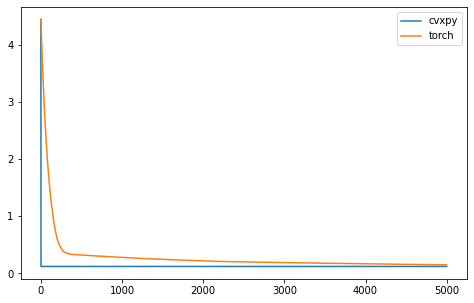

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(MAX_ITER + 1), cvxpy_errors, label='cvxpy')
ax.plot(range(MAX_ITER + 1), torch_errors, label='torch')
ax.legend()

print('cvxpy_time = {}'.format(cvxpy_time))
print('torch_time = {}'.format(torch_time))

fig.set_figheight(5)
fig.set_figwidth(8)
plt.show()